# Poster Notebook
Exporting data from our project for our Network Institute poster

Code by Etienne van de Bijl

In [1]:
import os
import pandas as pd 
import numpy as np
import collections
import matplotlib.pyplot as plt
from itertools import chain
from scipy.cluster import hierarchy
import seaborn as sns

# project code modules
os.sys.path.append('../project_code')
from data.bhsa import * #Load data
from markov.Markov_Chain import * #Transitions
from clustering.Clustering_analysis import *

dataset = get_data(books=["sbh","lbh"])

**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="{provenance of this corpus}">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/2017/0_home.html" title="{CORPUS.upper()} feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/Bhsa/" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 5.5.18</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/#search-templates" title="Search Templates Introduction and Reference">Search Reference</a>


This notebook online:
<a target="_blank" href="http://nbviewer.jupyter.org/github/Probabilistic_Language_Change/cody_NB/blob/master/.ipynb">NBViewer</a>
<a target="_blank" href="https://github.com/Probabilistic_Language_Change/cody_NB/blob/master/.ipynb">GitHub</a>


## Unique Values

In [2]:
dataset['phrase_functions']['Q'].keys()

dict_keys(['Genesis', 'Judges', '2_Kings', '1_Samuel', '2_Samuel', 'Joshua', 'Deuteronomy', '1_Kings', 'Leviticus', '1_Chronicles', '2_Chronicles', 'Ezra', 'Esther', 'Nehemiah', 'Song_of_songs', 'Ecclesiastes'])

In [3]:
features_unique = collections.defaultdict(dict)

# make count of unique values in dataset
for data_type, domains in dataset.items():
    unique_values = set()
    for domain, books in domains.items():
        for book, clauses in books.items():
            if data_type == "clause_types":
                feature_values = set(clauses[0])
            else:
                feature_values = set(chain(*clauses))
                
            unique_values = unique_values | feature_values
            
    features_unique[data_type] = list(unique_values)

    
print([len(v) for k,v in features_unique.items()])   
print(features_unique)

[21, 29, 13, 14]
defaultdict(<class 'dict'>, {'clause_types': ['ZIm0', 'xQtX', 'ZYq0', 'WayX', 'Way0', 'xYqX', 'WxQX', 'WXYq', 'WxY0', 'xQt0', 'Ptcp', 'ZYqX', 'xYq0', 'CPen', 'WYq0', 'WXQt', 'XYqt', 'Voct', 'XQtl', 'NmCl', 'WxYX'], 'phrase_functions': ['Adju', 'PrAd', 'Exst', 'Pred', 'PreO', 'Conj', 'Cmpl', 'Objc', 'NCoS', 'PrcS', 'Voct', 'NCop', 'Supp', 'Nega', 'Subj', 'ModS', 'Intj', 'PtcO', 'Frnt', 'Modi', 'PreS', 'PreC', 'Loca', 'ExsS', 'EPPr', 'Time', 'Ques', 'Rela', 'IntS'], 'phrase_types': ['PPrP', 'NegP', 'CP', 'PrNP', 'IPrP', 'NP', 'DPrP', 'InrP', 'AdjP', 'AdvP', 'PP', 'InjP', 'VP'], 'word_pos': ['conj', 'adjv', 'prde', 'nmpr', 'prin', 'prep', 'art', 'verb', 'intj', 'prps', 'subs', 'nega', 'advb', 'inrg']})


## Samples per Book

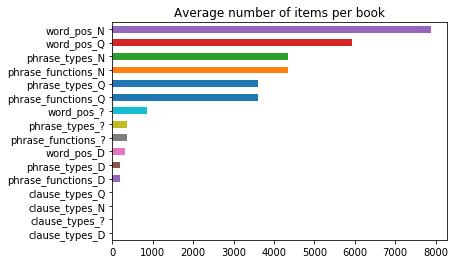

In [4]:
samples_ = collections.defaultdict(dict) # put counts here

# make the counts
for data_type in dataset.keys():
    for domain in dataset[data_type].keys():
        for book in dataset[data_type][domain].keys():
            items = dataset[data_type][domain][book]            
            if data_type == "clause_types":
                samples_[data_type+"_"+domain][book] = len(items[0])
            else:
                samples_[data_type+"_"+domain][book] = len(list(chain(*items)))
                
# dataframe and plot
df_samples = pd.DataFrame(samples_).fillna(0).mean(0).sort_values()
df_samples.plot(kind="barh", title="Average number of items per book")

## Remove Features with Too Few Datapoints


In [5]:
del dataset["clause_types"]

for f in dataset.keys():
    del dataset[f]["D"]
    del dataset[f]["?"]

removelist = []
for f in dataset.keys():
    for d in dataset[f].keys():
        for b in dataset[f][d].keys():
            n = samples_[f+"_"+d][b]
            if n < 100:
                removelist.append([f,d,b,f'samples: {n}'])

print('to be removed due to sample sizes:')
print('\n'.join(str(rem) for rem in removelist))
                
for i in removelist:
    del dataset[i[0]][i[1]][i[2]]          

features = ['phrase_functions', 'phrase_types', 'word_pos']
domain = ['N', 'Q']

to be removed due to sample sizes:
['phrase_functions', 'N', 'Song_of_songs', 'samples: 4']
['phrase_functions', 'N', 'Ecclesiastes', 'samples: 15']
['phrase_types', 'N', 'Song_of_songs', 'samples: 4']
['phrase_types', 'N', 'Ecclesiastes', 'samples: 15']
['word_pos', 'N', 'Song_of_songs', 'samples: 4']
['word_pos', 'N', 'Ecclesiastes', 'samples: 28']


## Make Markov Chains

In [6]:
dataset_trans = collections.defaultdict(dict)
dataset_MC = collections.defaultdict(dict)
for f in dataset.keys():
    for d in dataset[f].keys():
        df = dataset[f][d]
        transMatrix = transitionMatrix(df, True)
        dataset_trans[f][d] = transMatrix
        dataset_MC[f][d] = MCTransformation(transMatrix)
        
#Sanity check
dataset_trans["phrase_functions"]["N"]["Genesis"] 
dataset_MC["phrase_functions"]["N"]["Genesis"].sum(1) 

Adju            1.0
PrAd            1.0
Exst            1.0
Pred            1.0
PreO            1.0
Conj            1.0
Cmpl            1.0
Objc            1.0
NCoS            1.0
Clause_End      1.0
NCop            1.0
Supp            1.0
Nega            1.0
Subj            1.0
ModS            1.0
Clause_Begin    1.0
Intj            1.0
Frnt            1.0
Modi            1.0
PreS            1.0
PreC            1.0
Loca            1.0
Time            1.0
Ques            1.0
Rela            1.0
IntS            1.0
dtype: float64

## Calculate Distances Between Markov Chains

In [7]:
from scipy.spatial.distance import euclidean
#Distance
dataset_distance = collections.defaultdict(dict)
distan = []
distance_metric = "HELLINGER"

for f in dataset_MC.keys():
    for d in dataset_MC[f].keys():
        df = dataset_MC[f][d]
        
        distance_matrix = collections.defaultdict(dict)
        
        books = list(df.keys())
        for i in range(0, len(books)):
            for j in range(i+1, len(books)):
                MC_1 = df[books[i]]
                MC_2 = df[books[j]]
                
                distances = []
                
                if distance_metric == "TV":
                    dist_matrix = MC_1.subtract(MC_2).fillna(0)
                    for index, row in dist_matrix.T.iteritems():
                        dist = np.max(abs(row)) 
                        distances.append(dist)
                        info = [f,d,books[i],books[j],index,dist]
                        distan.append(info)
                
                if distance_metric == "HELLINGER":
                    dist_matrix = np.sqrt(MC_1).subtract(np.sqrt(MC_2)).fillna(0)
                    for index, row in dist_matrix.T.iteritems():
                        dist = np.linalg.norm(row, np.inf) / np.sqrt(2)
                        distances.append(dist)
                        info = [f,d,books[i],books[j],index,dist]
                        distan.append(info)
                
                if distance_metric == "Bhattacharyya":
                    dist_matrix = np.sqrt(MC_1.multiply(MC_2).fillna(0))
                    
                    for index, row in dist_matrix.T.iteritems():
                        som = np.sum(row)
                        if som > 0:
                            dist = -1 * np.log(som)
                            distances.append(dist)
                            info = [f,d,books[i],books[j],index,dist]
                            distan.append(info)
                
                if distance_metric == "alternative":
                    dist_matrix = np.sqrt(MC_1).subtract(np.sqrt(MC_2)).fillna(0)
                    for index, row in dist_matrix.T.iteritems():
                        dist = np.mean(abs(row))
                        distances.append(dist)
                        info = [f,d,books[i],books[j],index,dist]
                        distan.append(info)
                        
                distance_matrix[books[i]][books[j]] = np.mean(distances)
                distance_matrix[books[j]][books[i]] = np.mean(distances)
        dataset_distance[f][d] = pd.DataFrame(distance_matrix).fillna(0)

## Analyze Markov Chain Distances

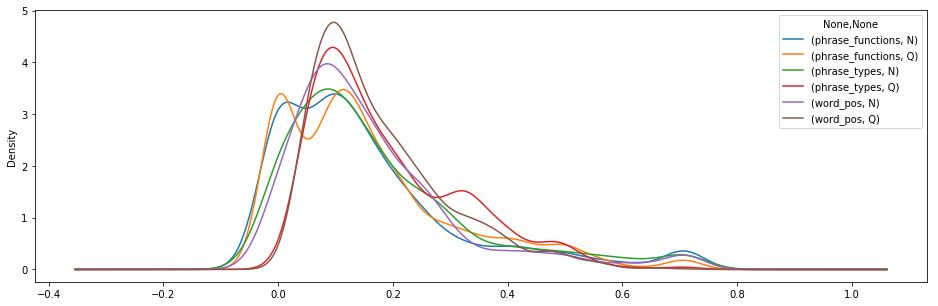

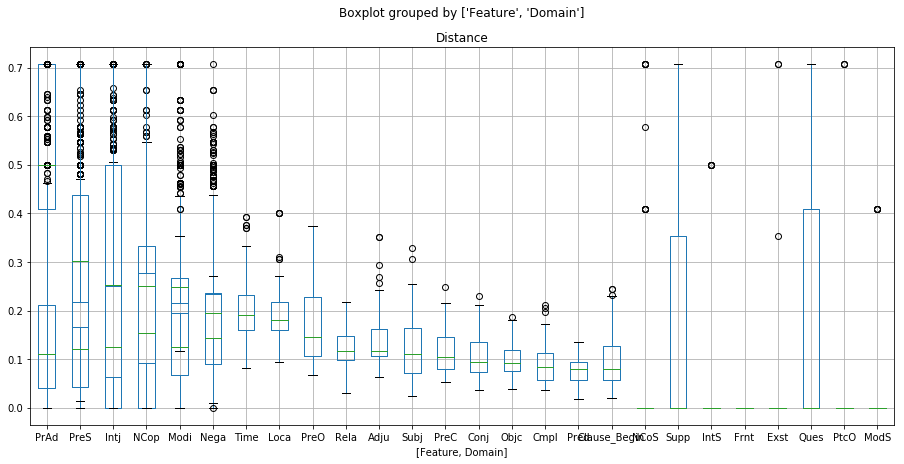

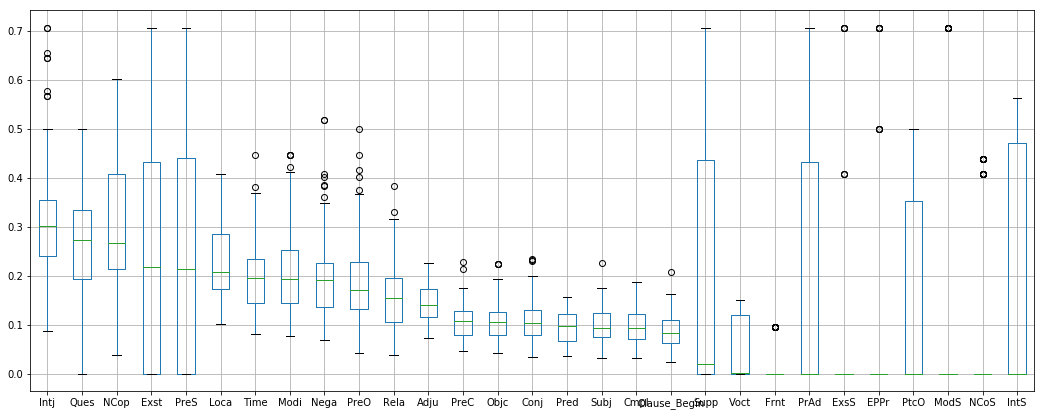

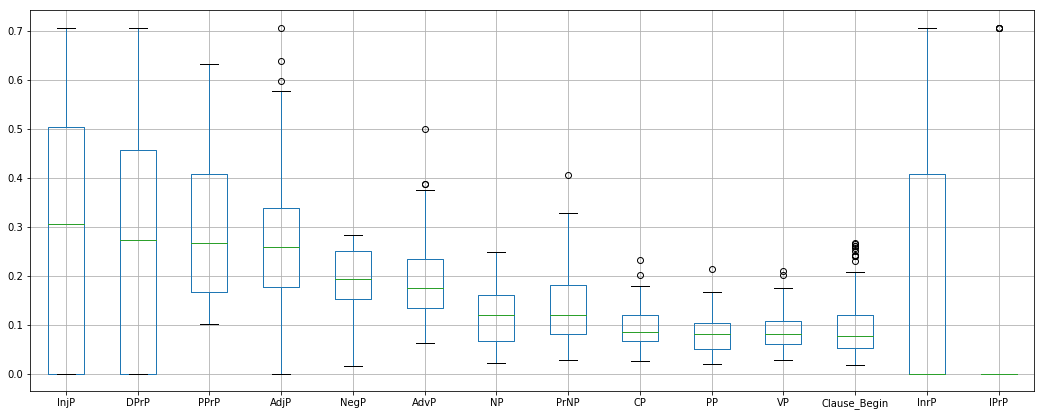

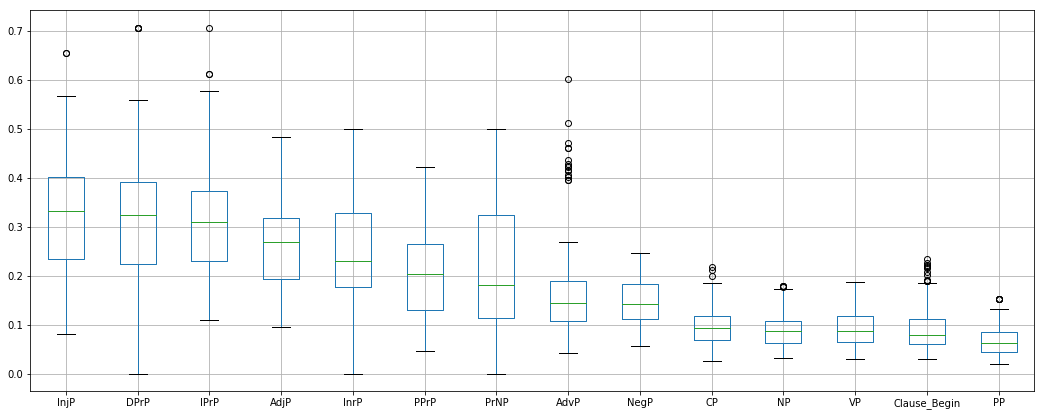

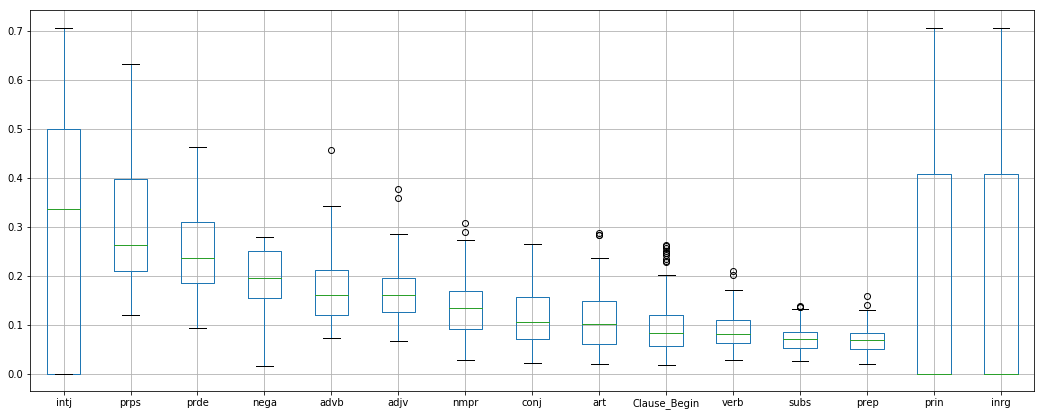

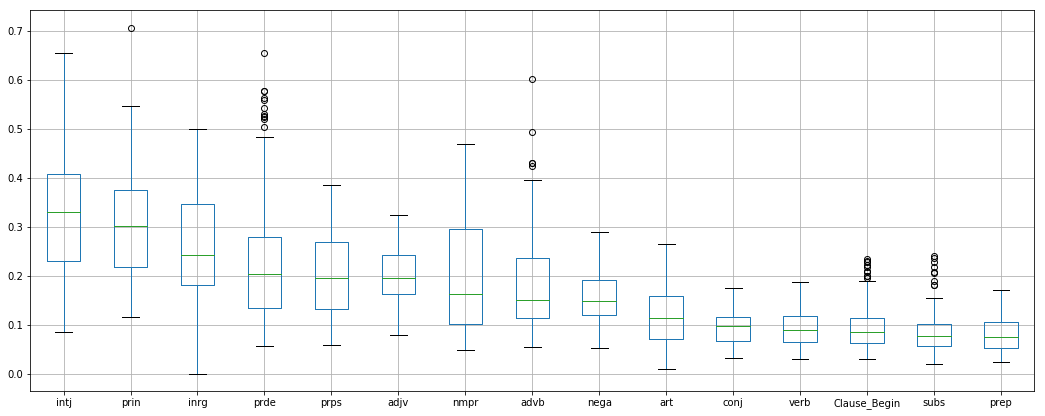

0.16622027861163596

In [8]:
results = pd.DataFrame(distan, columns=["Feature","Domain","Book1","Book2","Item","Distance"]) 

k =  results.groupby("Item")["Distance"].mean()
results= results[results.Item.isin(k[k > 0].index)]


results.groupby(["Feature","Domain"])["Distance"].plot(kind="density", legend=True, figsize=(16,5))
results.boxplot(column = "Distance", by = ["Feature","Domain"], figsize = (15,7))


for f in features:
    for d in domain:
        df = results[((results.Feature == f) & (results.Domain == d))]
        grouped = df.groupby(["Item"])
        df= pd.DataFrame({col:vals['Distance'] for col,vals in grouped})
        meds = df.median().sort_values(ascending=False)
        df[meds.index].boxplot(figsize = (18,7))
        plt.show()

v = results[(results.Book1.isin(sbh_books)) & (results.Book2.isin(sbh_books))]
w = results[(results.Book1.isin(lbh_books)) & (results.Book2.isin(lbh_books))]

v.Distance.mean()
w.Distance.mean()
v.Distance.std()
w.Distance.std()     

## Distance Between Distance Metrics

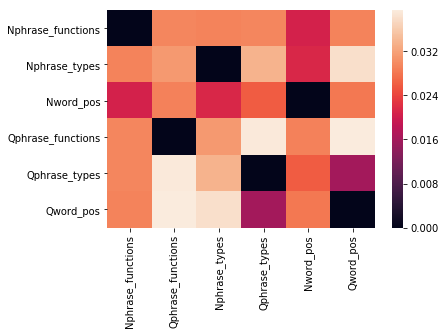

In [9]:
features = ['phrase_functions', 'phrase_types', 'word_pos']
domain = ['N', 'Q']

dataset_similarity = collections.defaultdict(dict)
for f1 in features:
    for d1 in domain:
        
        for f2 in features:
            for d2 in domain:
                df1 = dataset_distance[f1][d1]
                df2 = dataset_distance[f2][d2]
                distance = np.mean(abs(df1.subtract(df2)).mean())
                dataset_similarity[d1+f1][d2+f2] = distance

diff = pd.DataFrame(dataset_similarity)

sns.heatmap(diff)

## Make the Hierarchical Clusters

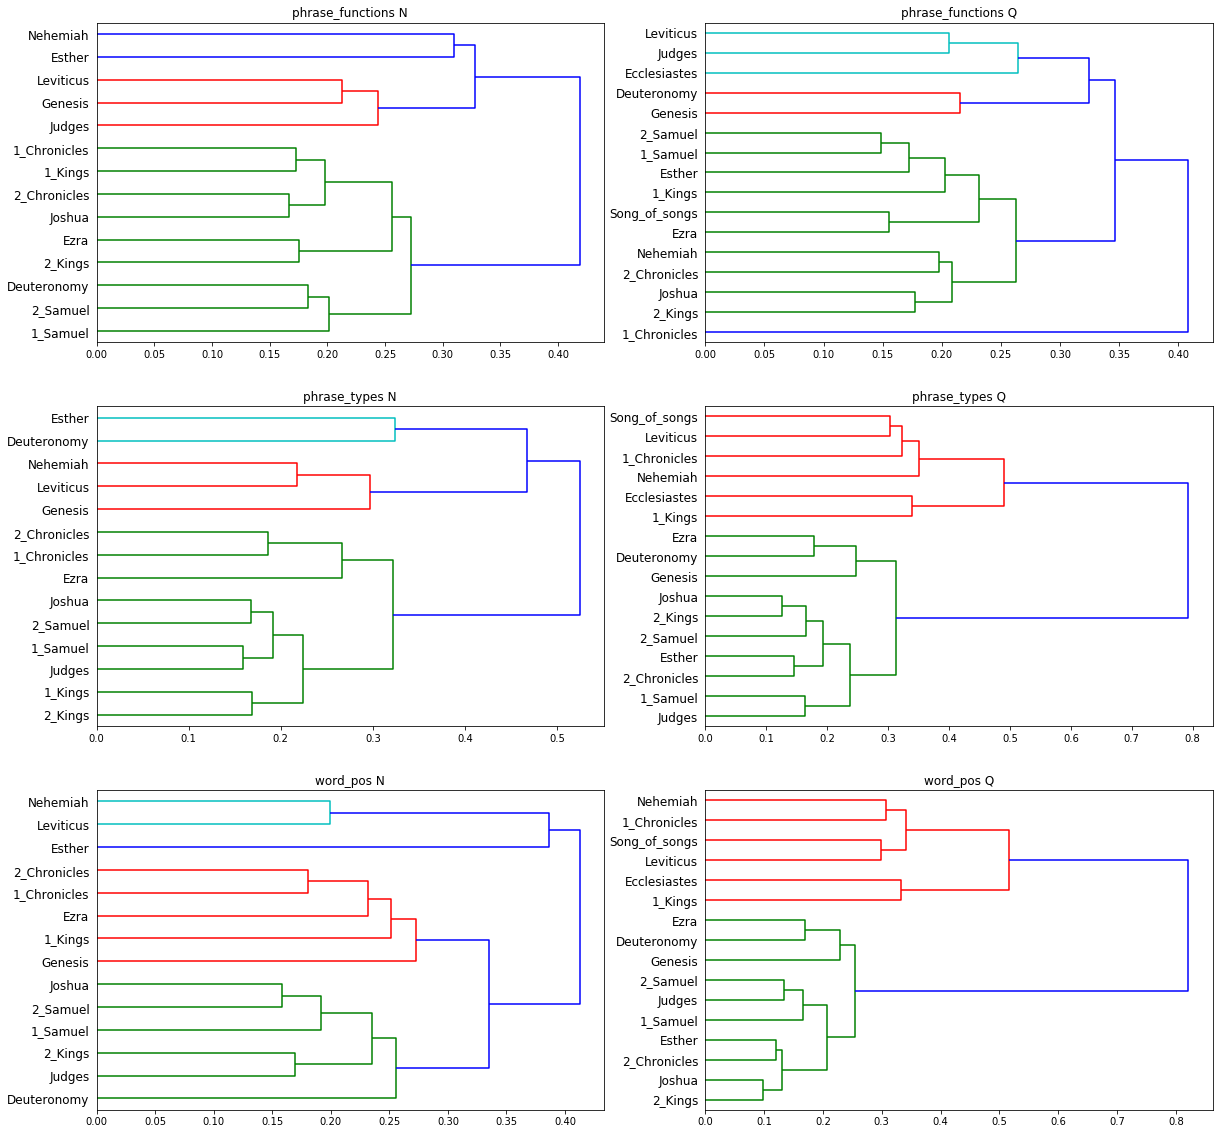

../project_code/clustering/Clustering_analysis.py:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method)


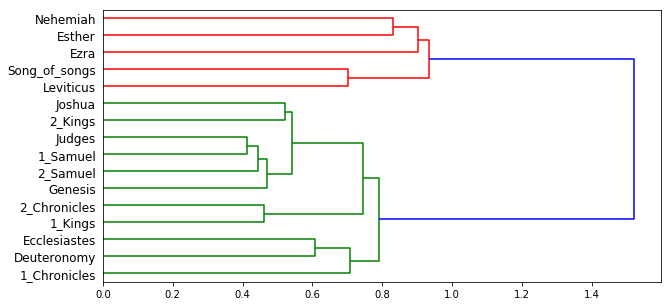

In [10]:
columns = len(domain)
rows = len(features)

#Per individual 
plt.figure(101, figsize = (20,20))
i = 1
for f in features:
    for d in domain:
        plt.subplot(rows, columns, i)
        dm = dataset_distance[f][d]
        Z = linkageFunction(dm, "ward")
        hierarchy.dendrogram(Z,labels=dataset_distance[f][d].columns, orientation = "right")
        plt.gca().set_title(f+" "+d)
        i = i +1

plt.savefig('/Users/cody/Desktop/hierarchies.png', dpi=300)
plt.show()

#Overall
mean_distance = dataset_distance['phrase_functions']['N'].fillna(0)
for f in features:
    for d in domain:
        if not f == 'phrase_functions' and not d == "N":
            dm = dataset_distance[f][d]
            mean_distance = mean_distance.add(dm, fill_value = 0)

plt.figure(101, figsize = (10,5))
Z = linkageFunction(mean_distance, "ward")
hierarchy.dendrogram(Z,labels=mean_distance.columns, orientation = "right")


plt.savefig('/Users/cody/Desktop/the_hierarchy.png', dpi=300)

## KMedoid Clustering

phrase_functions N
-0.07733767748816382


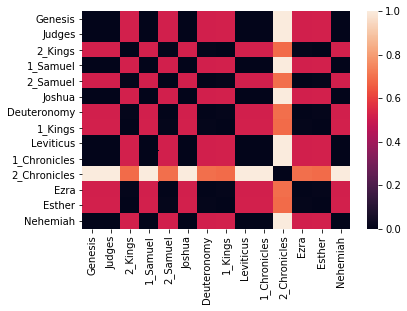

phrase_functions Q
0.022340475455294568


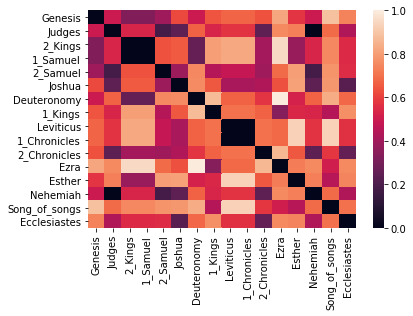

phrase_types N
0.21205667744431972


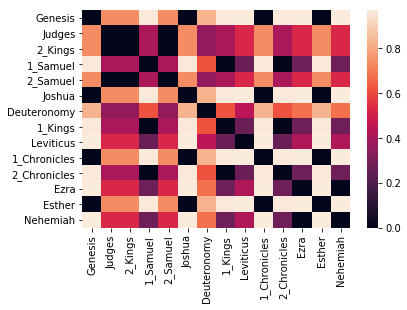

phrase_types Q
0.0025225957503654597


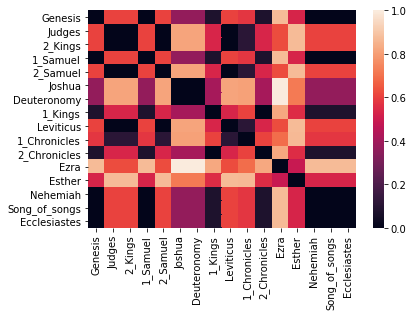

word_pos N
0.05855266503962448


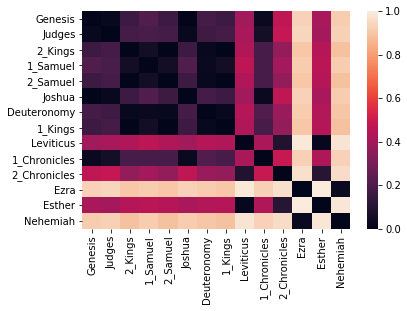

word_pos Q
-0.07015012515039608


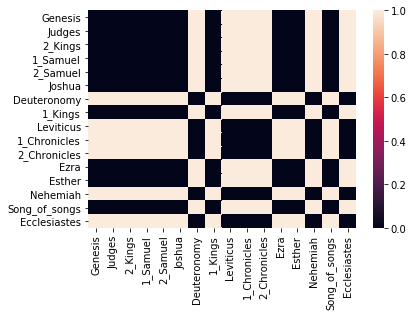

In [11]:
# =============================================================================
# Kmediods
# =============================================================================
   
from clustering.Kmediods import *
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
import seaborn as sns

for f in features:
    for d in domain:
        print(f,d)
        dm = dataset_distance[f][d]
        
        scores = pd.DataFrame(np.zeros((100,len(dm.columns))), columns = dm.columns)
        sil_sc = []
        for i in range(0,1000):
            M, C = kMedoids(np.array(dm), 2, tmax = 1000)
            
            for label, value in C.items():
                books = list(dm.index[value])
                for book in books:
                    scores.loc[i,book] = label   
            
            sil = silhouette_score(dm,labels = scores.loc[i,], metric='precomputed')
            sil_sc.append(sil)

        print(np.max(sil_sc))   
                    
                    
        agreements = pdist(scores.T, 'jaccard')
        ag = pd.DataFrame(squareform(agreements), index=dm.columns, columns = dm.columns)
        order = [a for a in list(("Genesis","Exods","Judges","2_Kings","1_Samuel","2_Samuel","Joshua","Deuteronomy","1_Kings","Leviticus")+lbh_books) if a in dm.columns]
        ag = ag[order]
        ag = ag.reindex(index = order)

        sns.heatmap(ag)
        plt.show()